# Sentinel-2 Composite Generation

Generate a image composite with Google Earth Engine and Cloud Score+

In [13]:
import concurrent
import io
import os
from typing import Literal

import cartopy.crs as ccrs
import contextily as cx
import ee
import geemap
import geopandas as gpd
import pandas as pd
import google.auth.transport.requests
from numpy.lib import recfunctions as rfn
import matplotlib.pyplot as plt
import numpy as np
import requests
from dotenv import load_dotenv
from google.api_core import retry
from IPython.display import Image
from shapely.geometry import box

from deepfreezer.grid import MajorTOMGrid
from deepfreezer.utils import ROOT_DIR

In [2]:
# Load environment variables from .env file
load_dotenv()
GEE_PROJECT = os.environ.get("GEE_PROJECT")


creds = ee.data.get_persistent_credentials()
auth_req = google.auth.transport.requests.Request()
creds.refresh(auth_req)
ee.Initialize(
    project=GEE_PROJECT, opt_url="https://earthengine-highvolume.googleapis.com"
)

## Load grid

In [3]:
# Import SGI
sgi = gpd.read_file(ROOT_DIR / "data/raw/inventory_sgi2016_r2020/SGI_2016_glaciers.shp")

# Clean file
sgi = sgi.drop(columns="pk_glacier")
sgi.gid = sgi.gid.astype(int)
sgi = sgi.set_index("gid", verify_integrity=True).sort_index().to_crs("EPSG:4326")
sgi_bounds = sgi.total_bounds
# Get a single shape of the union
sgi_union = sgi.union_all()

In [4]:
grid = MajorTOMGrid(dist=10_000)
cells = grid.get_cells(aoi=sgi_union, buffer_ratio=0.1)
cells.head()


,lon_idx,lat_idx,lon,lat,lon_spacing,id,utm_zone,geometry
4390551,1451,1512,6.957767,45.808383,0.128848,u0huw74m,EPSG:32632,"POLYGON ((6.94488 45.7994, 7.0995 45.7994, 7.0..."
4390552,1452,1512,7.086614,45.808383,0.128848,u0jh970m,EPSG:32632,"POLYGON ((7.07373 45.7994, 7.22835 45.7994, 7...."
4390553,1453,1512,7.215462,45.808383,0.128848,u0jhs5nj,EPSG:32632,"POLYGON ((7.20258 45.7994, 7.35719 45.7994, 7...."
4390554,1454,1512,7.344309,45.808383,0.128848,u0jhx55v,EPSG:32632,"POLYGON ((7.33142 45.7994, 7.48604 45.7994, 7...."
4393342,1448,1513,6.905701,45.898204,0.129079,u0hvj5s8,EPSG:32632,"POLYGON ((6.89279 45.88922, 7.04769 45.88922, ..."


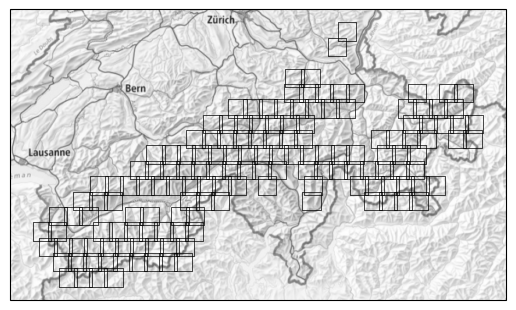

In [5]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={"projection": proj})
cells.plot(ax=ax, edgecolor="black", linewidth=0.5, color="None")

cx.add_basemap(
    ax,
    crs="epsg:4326",
    source=cx.providers.SwissFederalGeoportal.NationalMapGrey,
    attribution=False,
)


## Compute composite

In [6]:
BANDS = ["B4", "B3", "B2"]
QA_BAND = "cs_cdf"
CLEAR_THRESHOLD = 0.5

In [7]:
S2_TOA = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
S2_SR = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
S2_CSP = ee.ImageCollection("GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED")


def create_composite_cs(
    image_col: ee.ImageCollection,
    qa_band: Literal["cs", "cs_cdf"] = "cs_cdf",
    threshold: float = 0.6,
) -> ee.Image:
    """Create a Sentinel-2 composite in the desired ROI using the Google Cloud Score+"""

    return (
        image_col.linkCollection(S2_CSP, [qa_band])
        .map(lambda img: img.updateMask(img.select(qa_band).gte(threshold)))
        .median()
    )


In [8]:
test_cell = cells.iloc[0]
test_coords = (test_cell.lon, test_cell.lat)
test_crs = test_cell.utm_zone

test_start, test_end = "2023-06-01", "2023-09-30"

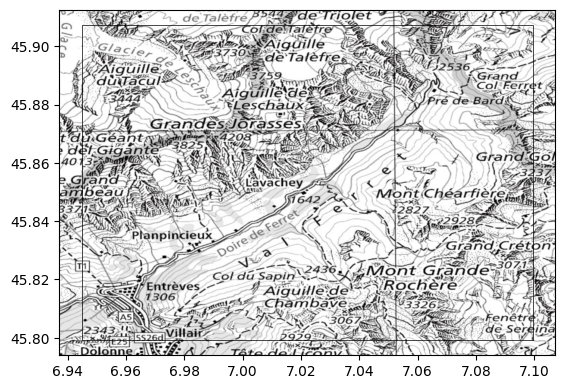

In [9]:
df_plot = gpd.GeoDataFrame([test_cell])

fig, ax = plt.subplots()

df_plot.plot(ax=ax, edgecolor="black", linewidth=0.5, color="None")

cx.add_basemap(
    ax,
    crs="epsg:4326",
    source=cx.providers.SwissFederalGeoportal.NationalMapGrey,
    attribution=False,
)


In [10]:
roi_coords = list(test_cell.geometry.exterior.coords)
roi_ee = ee.Geometry.Polygon(roi_coords)
point_ee = ee.Geometry.Point(test_cell.lon, test_cell.lat)

s2_filtered = S2_SR.filterDate(test_start, test_end).filterBounds(roi_ee).select(BANDS)
composite_cs = create_composite_cs(
    s2_filtered, qa_band=QA_BAND, threshold=CLEAR_THRESHOLD
)

visualization = {
    "min": 0,
    "max": 3000,
    "bands": ["B4", "B3", "B2"],
}

m = geemap.Map()
m.center_object(roi_ee, 12)
m.addLayer(composite_cs, visualization, "Cloud Score+")
m.addLayer(roi_ee, None, "Cell bounds (padded)")
m.addLayer(point_ee, {"color": "red"}, "Grid point")
m

Map(center=[45.85330207156129, 7.022190408015984], controls=(WidgetControl(options=['position', 'transparent_b…

## Download data with `computePixels`

In [11]:
def get_s2_composite(roi: ee.Geometry, start: str, end: str):
    """Get a two-month Sentinel-2 median composite in the ROI."""

    s2_filtered = S2_SR.filterBounds(roi).filterDate(start, end)
    return create_composite_cs(s2_filtered)


In [14]:
class GEEDownloader:
    def __init__(
        self,
        file_format: Literal["NPY", "GEO_TIFF"],
        grid_dist: tuple[int, int] | int,
        padding_ratio: float,
        scale: int | float,
        bands: str | list[str],
    ):
        """
        Initialize a GEEDownloader instance.

        Parameters
        ----------
        file_format : Literal["NPY", "GEO_TIFF"]
            Output file format. Must be either 'NPY' or 'GEO_TIFF'.
        grid_dist : int
            MajorTOM grid spacing in meters.
            Used to calculate the patch's height and width.
        padding_ratio : float
            Ratio of padding to apply around the patch.
        scale : int or float
            Pixel resolution in meters.
        bands : str or list of str
            Band or list of bands to download.
        """
        # Set file writer
        match file_format.lower():
            case "npy":
                self.file_format = "NPY"
                self.file_writer = self._write_numpy
            case "geo_tiff":
                self.file_format = "GEO_TIFF"
                self.file_writer = self._write_tiff
            case _:
                raise ValueError("`file_format` must be 'NPY' or 'GEO_TIFF'")

        # Calculate patch size in pixels
        self.grid_dist_px = int(grid_dist / scale)
        self.padding_px = int(self.grid_dist_px * padding_ratio)
        self.patch_size_px = self.grid_dist_px + 2 * self.padding_px

        self.scale = scale
        self.bands = bands

    @retry.Retry()
    def _get_patch(
        self, image: ee.Image, coords: tuple[float, float], crs: str
    ) -> bytes:
        """Get a patch relative to the coordinates of the bottom right corner"""

        coords = (test_cell.lon, test_cell.lat)
        proj = ee.Projection(crs).atScale(self.scale).getInfo()

        point = ee.Geometry.Point(coords)
        coords = point.transform(ee.Projection(crs)).getInfo()["coordinates"]

        # Get scales out of the transform.
        scale_x = proj["transform"][0]
        scale_y = -proj["transform"][4]

        # Offset to the upper left corner.
        offset_x = -scale_x * self.padding_px
        offset_y = -scale_y * (self.grid_dist_px + self.padding_px)

        request = {
            "expression": image,
            "fileFormat": self.file_format,
            "bandIds": self.bands,
            "grid": {
                "dimensions": {
                    "width": self.patch_size_px,
                    "height": self.patch_size_px,
                },
                "affineTransform": {
                    "scaleX": scale_x,
                    "shearX": 0,
                    "translateX": coords[0] + offset_x,
                    "shearY": 0,
                    "scaleY": scale_y,
                    "translateY": coords[1] + offset_y,
                },
                "crsCode": crs,
            },
        }
        return ee.data.computePixels(request)

    def _write_numpy(self, bytes_: bytes):
        return np.load(io.BytesIO(bytes_))

    def _write_tiff(self, bytes_: bytes):
        raise NotImplementedError

    @retry.Retry()
    def get_display_image(cell: pd.Series, image: ee.Image):
        """Helper to display a patch using notebook widgets."""
        roi_coords = list(cell.geometry.exterior.coords)
        roi_ee = ee.Geometry.Polygon(roi_coords)
        url = image.getThumbURL(
            {
                "region": roi_ee,
                "dimensions": "250",
                "format": "jpg",
                "min": 0,
                "max": 5000,
                "bands": ["B4", "B3", "B2"],
            }
        )

        r = requests.get(url, stream=True)
        if r.status_code != 200:
            raise google.api_core.exceptions.from_http_response(r)

        return r.content


In [41]:
dl = GEEDownloader(
    "NPY", grid_dist=10_000, padding_ratio=0.1, scale=10, bands=["B4", "B3", "B2"]
)

img = get_s2_composite(roi_ee, test_start, test_end).toInt16()
npy_bytes = dl._get_patch(img, test_coords, test_crs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0004..3.1008].


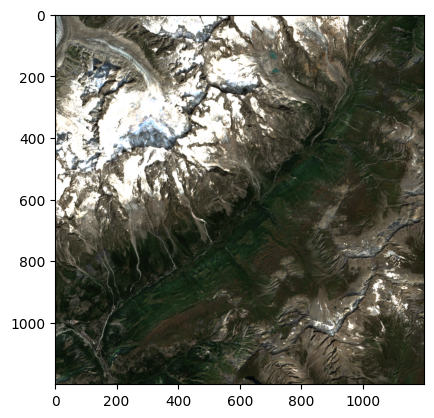

In [42]:
array = np.load(io.BytesIO(npy_bytes))
display_array = rfn.structured_to_unstructured(array[["B4", "B3", "B2"]]) / 5000
plt.imshow(display_array)


In [43]:
dl = GEEDownloader(
    file_format="GEO_TIFF",
    grid_dist=10_000,
    padding_ratio=0.1,
    scale=10,
    bands=["B4", "B3", "B2"],
)

tif_bytes = dl._get_patch(img, test_coords, test_crs)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0004..3.1008].


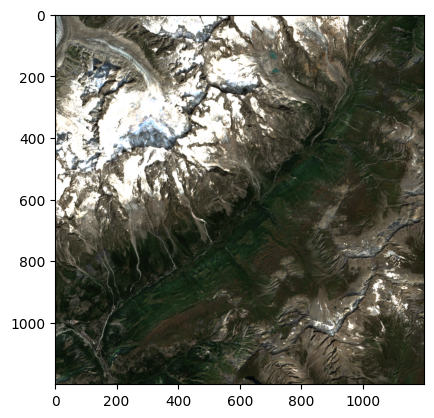

In [44]:
from rasterio.io import MemoryFile
import rasterio

with MemoryFile(tif_bytes) as memfile:
    src = memfile.open()
    array = src.read()

plt.imshow(array.transpose([1, 2, 0]) / 5000)

In [45]:
# Register GDAL format drivers and configuration options with a
# context manager.
with MemoryFile(tif_bytes) as memfile:
    src = memfile.open()
    array = src.read()
    profile = src.profile
    with rasterio.open("rasterio_int.tif", "w", **profile) as dst:
        dst.write(array)


In [ ]:
# TYPE = np.uint16

# # Register GDAL format drivers and configuration options with a
# # context manager.
# with MemoryFile(tif_bytes) as memfile:
#     src = memfile.open()
#     array = src.read()
#     with rasterio.Env():
#         profile = src.profile
#         profile["dtype"] = TYPE
#         with rasterio.open("rasterio_int.tif", "w", **profile) as dst:
#             dst.write(array.astype(TYPE))